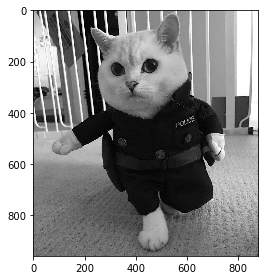

In [94]:
from skimage import io
from skimage import color
import skimage
import numpy as np
import heapq
from itertools import groupby
image = skimage.img_as_ubyte(io.imread('Images/catcop.jpg'))
image = skimage.color.rgb2gray(image)
io.imshow(image)

In [55]:
def encode_image_RLE(image):
    flat = image.flatten()
    last = flat[0]
    encoded = []
    count = 1
    for i in range(1, len(flat)):
        if flat[i] == last:
            count += 1
        else:
            encoded.append((last, count))
            last = flat[i]
            count = 1
    encoded.append((last, count))
    return encoded

In [64]:
def decode_image_RLE(encoded, width, height):
    decoded = []
    for i, j in encoded:
        decoded += [i] * j
    decoded = np.array(decoded)
    return decoded.reshape(height, width)

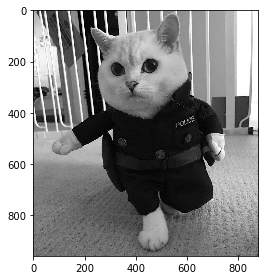

In [69]:
encoded_image_RLE = encode_image_RLE(image)
decoded_image_RLE = decode_image_RLE(encoded_image_RLE, image.shape[1], image.shape[0])
io.imshow(decoded_image_RLE)

In [85]:
class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None
        
    def set_children(self, left, right):
        self.left = left
        self.right = right
        
    def __lt__(self, other):
        return self.freq < other.freq
    
    def __repr__(self):
        return f'Code: {self.char}: Freq: {self.freq}'

In [86]:
class HuffmanCoder:
    def __init__(self):
        self.en_codes = {}
        self.de_codes = {}
        self.height = 0
        self.width = 0
    
    def get_codes(self, parent_code, node):
        if node.char:
            if not parent_code:
                self.en_codes[node.char] = '0'
            else:
                self.en_codes[node.char] = parent_code
        else:
            self.get_codes(parent_code + '0', node.left)
            self.get_codes(parent_code + '1', node.right)
    
    def build_frequency_pairs(self, x):
        result = [HuffmanNode(key, len(list(group))) for key, group in groupby(sorted(x))]
        heapq.heapify(result)
        return result
    
    def build_huff_tree(self, freq_pairs):
        while len(freq_pairs) > 1:
            left = heapq.heappop(freq_pairs)
            right = heapq.heappop(freq_pairs)
            node = HuffmanNode(None, left.freq + right.freq)
            node.set_children(left, right)
            heapq.heappush(freq_pairs, node)
        return freq_pairs
    
    def encode(self, img):
        self.height, self.width = img.shape
        x = img.flatten()
        freq_pairs = self.build_frequency_pairs(x)
        huff_tree = self.build_huff_tree(freq_pairs)
        self.get_codes('', huff_tree[0])
        self.de_codes = {v: k for k, v in self.en_codes.items()}
        return ''.join([self.en_codes[pixel] for pixel in x])
        
    def decode(self, code):
        start = 0
        end = 1
        result = []
        while start < len(code):
            if code[start:end] in self.de_codes:
                result.append(self.de_codes[code[start:end]])
                start = end
                end = start + 1
            else:
                end += 1
        return np.array(result).reshape((self.height, self.width))


In [ ]:
huff_encoder = HuffmanCoder()
huffman_image = huff_encoder.decode(huff_encoder.encode(image))